In [1]:
from PIL import Image
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import os

Data collected from Google earth engine. I've made samples of Sviatoshyn district in Kyiv, and manualy marked some points, that I have classify. There are 24 photos from 1/1/2022 to 1/11/2022
https://code.earthengine.google.com/00c9d681b421530bab2a2b63d76de54b

Here is the sample of my data


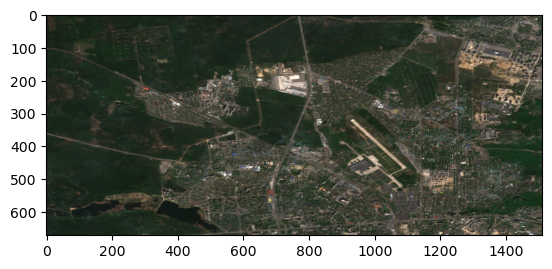

In [2]:
print("Here is the sample of my data")
plt.imshow(np.clip(cv2.imread('data/image2022-05-01.tif', cv2.IMREAD_UNCHANGED)*3, 0, 1))

In [3]:
images = []
labels=[]

lavina = (750, 150) 
airport = (1000, 400) 
retr = (1350, 100) 
lake = (430, 571) 
city = (750, 550)
size1 = (200, 200)

path_start='data/'
for filename in os.listdir(path_start):        
    image = np.clip(cv2.imread(os.path.join(path_start, filename), cv2.IMREAD_UNCHANGED)*3, 0, 1)

    images.append(cv2.getRectSubPix(image, size1, lavina))
    labels.append('lavina')
    
    images.append(cv2.getRectSubPix(image, size1, airport))
    labels.append('airport')
        
    images.append(cv2.getRectSubPix(image, size1, retr))
    labels.append('retroville')
    
    images.append(cv2.getRectSubPix(image, size1, lake))
    labels.append('lake')
    
    images.append(cv2.getRectSubPix(image, size1, city))
    labels.append('city')   
    

In [4]:
images=np.array(images)
labels=np.array(labels)

print(images.shape)
print(labels.shape)

(120, 200, 200, 3)
(120,)


In [5]:
np.where(labels=='lavina')

(array([  0,   5,  10,  15,  20,  25,  30,  35,  40,  45,  50,  55,  60,
         65,  70,  75,  80,  85,  90,  95, 100, 105, 110, 115], dtype=int64),)

C:\Users\koles\anaconda3\lib\site-packages\matplotlib\cm.py:440: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


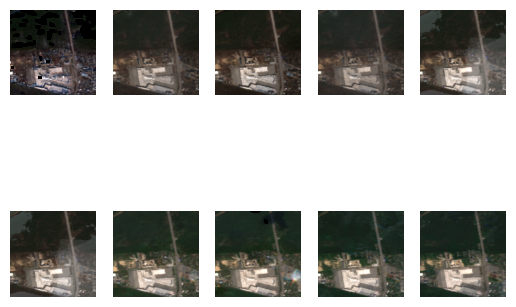

In [6]:
fig,axs=plt.subplots(nrows=2, ncols=5)
for i in range(5):
    axs[0,i].imshow(images[5*i])
    axs[1,i].imshow(images[25+(5*i)])
    axs[0, i].axis('off')
    axs[1, i].axis('off')

plt.show()


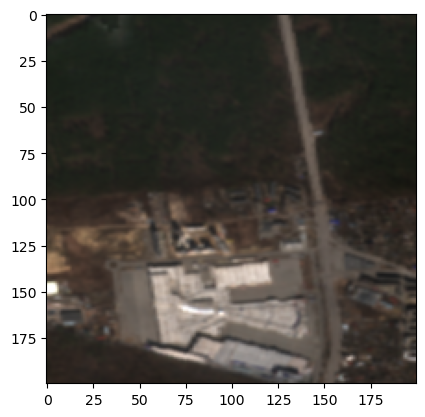

In [7]:
plt.imshow(images[5])

In [8]:
for lbl in np.unique(labels):
    arr = images[np.where(labels==lbl)]
    mean_values = np.nan_to_num((np.mean(arr, axis=(0))))
    for im in images[np.where(labels==lbl)]:
        nan_indices = np.isnan(im)
        im[nan_indices] = mean_values[nan_indices]
    print(np.sum(np.isnan(images[np.where(labels==lbl)])))
    
images = np.nan_to_num(images)

7035
4632
17874
12747
14190


In [9]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.05,
    height_shift_range=0.05,
    shear_range=0.05,
    zoom_range=0.05,
    horizontal_flip=False,
    fill_mode='nearest'
)

augmentation_factor = 3

augmented_images = []
augmented_labels = []

for i in range(len(images)):
    img = np.expand_dims(images[i], axis=0)
    label = labels[i]

    augmented_data = datagen.flow(img, batch_size=1, save_to_dir=None).next()

    for j in range(augmentation_factor):
        augmented_images.append(np.squeeze(augmented_data))
        augmented_labels.append(label)

augmented_images = np.array(augmented_images)
augmented_labels = np.array(augmented_labels)
print(augmented_images.shape)
print(augmented_labels.shape)

(360, 200, 200, 3)
(360,)


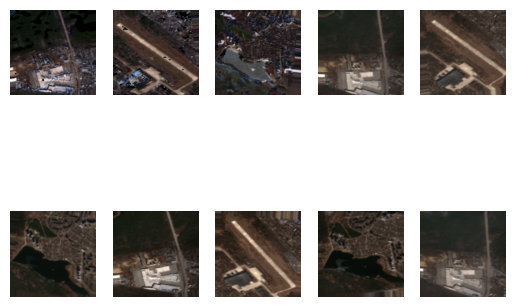

In [10]:
fig,axs=plt.subplots(nrows=2, ncols=5)
for i in range(5):
    axs[0,i].imshow(augmented_images[5*i])
    axs[1,i].imshow(augmented_images[25+(5*i)])
    axs[0, i].axis('off')
    axs[1, i].axis('off')

plt.show()

In [11]:
images=np.concatenate((images, augmented_images), axis=0)
labels=np.concatenate((labels, augmented_labels), axis=0)
print(images.shape)
print(labels.shape)
pd.Series(labels).value_counts()

(480, 200, 200, 3)
(480,)


lavina        96
airport       96
retroville    96
lake          96
city          96
dtype: int64

In [12]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(sparse=False)
labels_encoded = encoder.fit_transform(labels.reshape(-1, 1))
labels_encoded

array([[0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [13]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test=train_test_split(images,labels_encoded, test_size=.3)

In [14]:
import tensorflow as tf
from tensorflow.keras import layers, models

cnn = models.Sequential([
    layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(200, 200, 3),kernel_regularizer=tf.keras.regularizers.l2(l=0.01)),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),
    
    layers.Flatten(),
    layers.Dense(32, activation='relu'),
    layers.Dense(5, activation='softmax')
])
cnn.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])
cnn.summary()
cnn.fit(X_train, y_train, epochs=5, validation_split=.2)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 198, 198, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 99, 99, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 99, 99, 32)        0         
                                                                 
 flatten (Flatten)           (None, 313632)            0         
                                                                 
 dense (Dense)               (None, 32)                10036256  
                                                                 
 dense_1 (Dense)             (None, 5)                 165       
                                                        

In [15]:
cnn.evaluate(X_test, y_test)

5/5 [==============================] - 0s 61ms/step - loss: 0.0502 - accuracy: 1.0000


[0.05020557716488838, 1.0]